In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


## loading model from saved file

In [2]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import pickle




# loading model
pickle_in = open(r"F:\pneumonia\000 P R O J E C T S\models\resnet_50_without_fc.pickle"  , 'rb')
resnet_50 = pickle.load (pickle_in)

# Let's print our layers again 
for (i,layer) in enumerate(resnet_50.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)
  

0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 Activation False
5 ZeroPadding2D False
6 MaxPooling2D False
7 Conv2D False
8 BatchNormalization False
9 Activation False
10 Conv2D False
11 BatchNormalization False
12 Activation False
13 Conv2D False
14 Conv2D False
15 BatchNormalization False
16 BatchNormalization False
17 Add False
18 Activation False
19 Conv2D False
20 BatchNormalization False
21 Activation False
22 Conv2D False
23 BatchNormalization False
24 Activation False
25 Conv2D False
26 BatchNormalization False
27 Add False
28 Activation False
29 Conv2D False
30 BatchNormalization False
31 Activation False
32 Conv2D False
33 BatchNormalization False
34 Activation False
35 Conv2D False
36 BatchNormalization False
37 Add False
38 Activation False
39 Conv2D False
40 BatchNormalization False
41 Activation False
42 Conv2D False
43 BatchNormalization False
44 Activation False
45 Conv2D False
46 Conv2D False
47 BatchNormalization False
48 BatchNor

C:\Users\Asus\.conda\envs\tf\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## creating the dence top layers

In [9]:
def addTopModel(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    #top_model = GlobalAveragePooling2D()(top_model)
    top_model = Flatten(name = "flatten")(top_model)
    #top_model = Dense(1024,activation='relu')(top_model)
    #top_model = Dense(1024,activation='relu')(top_model)
    #top_model = Dropout(0.5)(top_model)
    top_model = Dense(128,activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(64,activation='relu')(top_model)
    top_model = Dropout(0.4)(top_model)
    top_model = Dense(16,activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(num_classes,activation='sigmoid')(top_model)
    return top_model


## adding the top to the loaded model 

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

num_classes = 2

FC_Head = addTopModel(resnet_50, num_classes)

model = Model(inputs=resnet_50.input, outputs=FC_Head)

print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

## dataset directories 

In [11]:
train_dir = r"F:\pneumonia\000 P R O J E C T S\pneumonia\New folder\dataset\train"
val_dir = r"F:\pneumonia\000 P R O J E C T S\pneumonia\New folder\dataset\val"


## data augmentation

In [23]:
# resnet50 was designed to work on 224 x 224 pixel input images sizes
img_rows = 224
img_cols = 224
## data augmentation
batch_size = 32
'''
# resnet required preprocessing
train_datagen = ImageDataGenerator(dtype='float32',
                                   preprocessing_function=preprocess_input)


validation_datagen = ImageDataGenerator(dtype='float32',
                                        preprocessing_function=preprocess_input)
'''
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip= False,
      fill_mode='nearest'#)
      ,preprocessing_function = preprocess_input)

validation_datagen = ImageDataGenerator(
                                        rescale=1./255
                                        ,preprocessing_function = preprocess_input)
# applying on the data 
train_generator = train_datagen.flow_from_directory(
        train_dir,
        #color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
 
validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        #color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

Found 31063 images belonging to 2 classes.
Found 5354 images belonging to 2 classes.


## fitting the model 

In [24]:
from keras import optimizers
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

                     
checkpoint = ModelCheckpoint(r"F:\pneumonia\000 P R O J E C T S\pneumonia\New folder\codes\checkpoints\resnet_pneumonia_01.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 1,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

# We use a very small learning rate

opt = optimizers.Adam(lr = 0.00005, decay = 1e-6)
#opt = optimizers.Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#opt1= Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss = 'binary_crossentropy',
              optimizer = opt,
              metrics = ['accuracy'])

nb_train_samples = 31063   
nb_validation_samples = 5349
epochs = 3
batch_size = 32



In [25]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size
    )

import pickle 
pickle_out = open(r"F:\pneumonia\000 P R O J E C T S\pneumonia\New folder\codes\checkpoints\checkpoint_resnet_p1.pickle" , 'wb')
pickle.dump (checkpoint , pickle_out)
pickle_out.close()

Epoch 1/3
970/970 [==============================] - 1078s 1s/step - loss: 0.5669 - accuracy: 0.7583 - val_loss: 0.7368 - val_accuracy: 0.2279

Epoch 00001: val_loss improved from inf to 0.73675, saving model to F:\pneumonia\000 P R O J E C T S\pneumonia\New folder\codes\checkpoints\resnet_pneumonia_01.h5
Epoch 2/3
970/970 [==============================] - 1053s 1s/step - loss: 0.5532 - accuracy: 0.7653 - val_loss: 0.7186 - val_accuracy: 0.2287

Epoch 00002: val_loss improved from 0.73675 to 0.71858, saving model to F:\pneumonia\000 P R O J E C T S\pneumonia\New folder\codes\checkpoints\resnet_pneumonia_01.h5
Epoch 3/3
970/970 [==============================] - 1059s 1s/step - loss: 0.5414 - accuracy: 0.7688 - val_loss: 0.7975 - val_accuracy: 0.2279

Epoch 00003: val_loss did not improve from 0.71858

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


## curves

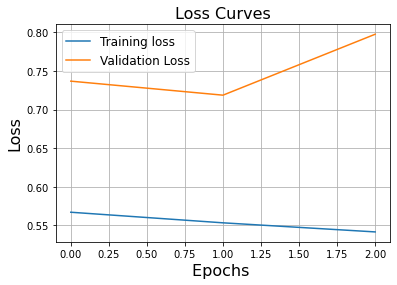

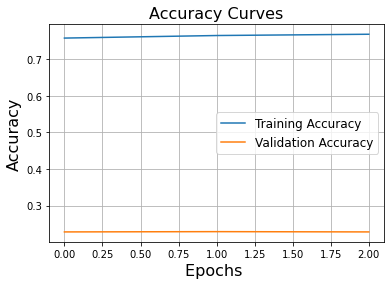

In [26]:
# Loss Curves
#plt.figure(figsize=[10,8])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training loss', 'Validation Loss'],fontsize=12)
plt.grid()
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()
 
# Accuracy Curves
#plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=12)
plt.grid()
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
plt.show()

In [ ]:
##

Found 5354 images belonging to 2 classes.
Confusion Matrix
[[   0 4134]
 [   0 1220]]
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4134
           1       0.23      1.00      0.37      1220

    accuracy                           0.23      5354
   macro avg       0.11      0.50      0.19      5354
weighted avg       0.05      0.23      0.08      5354



C:\Users\Asus\.conda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


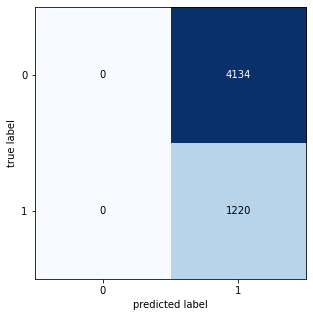

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.models import load_model
import pickle 

# We need to recreate our validation generator with shuffle = false
validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        #color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

nb_train_samples = 21380 
nb_validation_samples = 5349


#Confution Matrix and Classification Report
#Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

CM = confusion_matrix(validation_generator.classes, y_pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [ ]:
! pip install numba

In [34]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()